## Benchmarking 3
This notebook investigates how the dimensions of tall-and-skinny matrices impact the execution time of different algorithms. We will fix the number of columns to $n=4$ while varying the number of rows from $10^5$ to $6\times 10^7$ by building random matrices on each worker. Due to an 8GB memory constraint per virtual machine, we are limited in matrix size and aim to analyze parallel algorithm performance without the results being skewed by slow disk read/write operations. This approach differs from the work of Benson et al. (2013), who relied on the Hadoop framework and saved resulting matrices to a distributed file system. 

In [1]:
from dask.distributed import Client, wait
from dask import delayed, persist
import dask.array as da

from functions import cholesky_tsqr, indirect_tsqr, direct_tsqr
import numpy as np

import time
import gc

In [2]:
def benchmark(client : Client, X_da : da.Array, algorithm : callable, rep : int = 20, verbose : bool = False) -> list:
    '''
    Benchmark a given QR algorithm on a Dask array
    
    Parameters
    ----------
    client : dask.distributed.Client
        Dask client to manage the computation.
    X_da : dask.array.Array
        Input matrix (m x n), stored as a Dask array.
    algorithm : delayed function
        The algorithm to benchmark. Should return Q, R.
    rep : int, optional
        Number of repetitions for the benchmark (default is 20).
    verbose : bool, optional
        If True, prints progress information (default is False).

    Returns
    -------
    times : list
        List of execution times for each repetition.
    '''
    res = []
    if verbose:
        print("Fun:", algorithm.__name__, ", completion status: ", end="")
    
    for i in range(rep):
        if verbose:
            print(i, end=" ")

        start = time.time()

        # Launch the function and trigger the computation
        # by persisting the results
        Q, R = algorithm(X_da)
        Q, R = persist(Q, R)
        wait([Q, R])

        end = time.time()
        res.append(end - start)

        # Resetting the client memory by cancelling
        # the futures and triggering garbage collection
        client.cancel([Q, R])
        gc.collect()
        client.run(gc.collect)

    if verbose:
        print()

    return res

def write_stats_dim(filename : str, param : str, times : list):
    '''
    Write the statistics of the benchmark to a file.

    | param | avg | std | med | mad |

    Parameters
    ----------
    filename : str
        The name of the file to write the statistics to.
    param : str
        The name of the parameter being tested.
    times : list
        List of execution times from the benchmark.
    '''
    avg = np.mean(times)
    std = np.std(times)
    med = np.median(times)
    mad = np.median(np.abs(times - med))
    with open(filename, "a") as f:
        f.write(f"{param} {avg} {std} {med} {mad}\n")

def create_dataset(file_path : str, shape : tuple, dtype : type, chunk_size : int):
    '''
    Create a  random dataset and save it to a file.
    
    Parameters
    ----------
    file_path : str
        The path to the file where the dataset will be saved.
    shape : tuple
        The shape of the dataset (m, n).
    dtype : data-type
        The desired data-type for the array.
    chunk_size : int
        The number of rows per chunk to write to the file.
    '''
    m, n = shape
    
    with open(file_path, "a") as f:
        for _ in range(m // chunk_size):
            # Generate a chunk of random data
            X_chunk = np.random.randn(chunk_size, n).astype(dtype)
            np.savetxt(f, X_chunk, delimiter=",")

        # Handle any remaining rows
        if m % chunk_size != 0:
            X_chunk = np.random.randn(m % chunk_size, n).astype(dtype)
            np.savetxt(f, X_chunk, delimiter=",")

In [3]:
m = [int(1e5), int(5e5), int(1e6), int(5e6), int(1e7), 
    int(2e7), int(3e7), int(4e7), int(5e7), int(6e7)]   # Number of rows
n = 4                                                   # Number of columns (fixed n << m)

# Number of repetitions for each test
rep = 20

---
## Sequential test
Numpy's `numpy.linalg.qr` function relies on underlying LAPACK routine `dgeqrf`, which can utilize multiple cores depending on the hardware and software configuration. To enforce a sequential calculation for accurate benchmarking, we built a Dask cluster with a single worker and a maximum of 8GB of memory. This setup, limited by the single machine's memory, constrains the maximum size of the matrix we can benchmark.

#### **Local system specifications**
- CPU: Intel Core i7-14700K (20 Core, 28 Threads - Turbo Frequency 5.6 GHz)
- RAM: 32 GB (DDR5)
#### **Cloud Veneto VMs system specifications**
- CPU: 4 VCPU
- RAM: 8 GB
- DISK: 25 GB

In [ ]:
# Initialize Dask client with a single worker (LOCAL SETUP)
client = Client(
    n_workers=1,
    threads_per_worker=1,
    memory_limit="16GB",
)

print("Dashboard:", client.dashboard_link)

Dashboard: http://127.0.0.1:8787/status


In [4]:
from dask.distributed import Client, SSHCluster

cluster = SSHCluster(
    ["10.67.22.154", "10.67.22.216"],
    connect_options={"known_hosts": None},
    remote_python="/home/ubuntu/miniconda3/bin/python",
    scheduler_options={"port": 8790, "dashboard_address": ":4455"},
    worker_options={
        "nprocs": 1,       # N. of processess per VM. CloudVeneto's large VMs offers 4-core CPU, but for now we only spawn 1 process per VM
        "nthreads": 1,     # N. of threads per process
        "memory_limit" : "8GB",
    }
)

client = Client(cluster)
print(client)
print(cluster)
print("Dashboard:", client.dashboard_link)

2025-09-15 11:22:46,756 - distributed.deploy.ssh - INFO - 2025-09-15 11:22:46,755 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-09-15 11:22:46,776 - distributed.deploy.ssh - INFO - 2025-09-15 11:22:46,776 - distributed.scheduler - INFO - State start
2025-09-15 11:22:46,780 - distributed.deploy.ssh - INFO - 2025-09-15 11:22:46,780 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.154:8790
/home/ubuntu/miniconda3/lib/python3.13/site-packages/distributed/deploy/ssh.py:100: FutureWarning: The nprocs argument will be removed in a future release. It has been renamed to n_workers.
  warnings.warn(
2025-09-15 11:22:49,986 - distributed.deploy.ssh - INFO - 2025-09-15 11:22:49,983 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.216:43041'
2025-09-15 11:22:50,378 - distributed.deploy.ssh - INFO - 2025-09-15 11:22:50,375 - distributed.diskutils - 

<Client: 'tcp://10.67.22.154:8790' processes=0 threads=0, memory=0 B>
SSHCluster(SSHCluster, 'tcp://10.67.22.154:8790', workers=0, threads=0, memory=0 B)
Dashboard: http://10.67.22.154:4455/status


In [11]:
# Due to memory constraints on a single worker (8GB), we cannot 
# perform all matrix size operations sequentially. 
# To ensure fair benchmarking, it is critical to avoid memory spills to disk, 
# which would artificially inflate the time measurements.
m_seq = [int(1e5), int(5e5), int(1e6), int(5e6), int(1e7), int(2e7), int(3e7), int(4e7)]

for mi in m_seq:
    # Creation of a random dask array inside the worker
    X_np = da.random.random((mi, n))
    X_np.persist()
    print(f"Input matrix A: m = {X_np.shape[0]}, n = {X_np.shape[1]}")
    print(f"Total size of A: {X_np.nbytes / 1e6} MB")

    times = []
    for i in range(rep):
        start = time.time()

        # Numpy QR decomposition. We use persist to trigger
        # the computation and avoid data transfering
        QR = delayed(np.linalg.qr)(X_np)
        QR = client.persist([QR])
        wait([QR])

        end = time.time()
        times.append(end - start)

        # Clean memory from previous computations
        client.cancel(QR)
        gc.collect()
        client.run(gc.collect)

    # Clean memory from previous computations    
    client.cancel(X_np)
    gc.collect()
    client.run(gc.collect)

    # Save statistics
    print(f"NumPy: mean time {np.mean(times):.2f} s, std {np.std(times):.2f} s")
    write_stats_dim(f"./data/Size_NumPy.txt", X_np.shape[0], times)
    print()

Input matrix A: m = 100000, n = 4
Total size of A: 3.2 MB
NumPy: mean time 0.05 s, std 0.02 s

Input matrix A: m = 500000, n = 4
Total size of A: 16.0 MB
NumPy: mean time 0.12 s, std 0.01 s

Input matrix A: m = 1000000, n = 4
Total size of A: 32.0 MB
NumPy: mean time 0.22 s, std 0.01 s

Input matrix A: m = 5000000, n = 4
Total size of A: 160.0 MB
NumPy: mean time 1.08 s, std 0.01 s

Input matrix A: m = 10000000, n = 4
Total size of A: 320.0 MB
NumPy: mean time 2.15 s, std 0.02 s

Input matrix A: m = 20000000, n = 4
Total size of A: 640.0 MB
NumPy: mean time 4.23 s, std 0.05 s

Input matrix A: m = 30000000, n = 4
Total size of A: 960.0 MB
NumPy: mean time 6.26 s, std 0.04 s

Input matrix A: m = 40000000, n = 4
Total size of A: 1280.0 MB
NumPy: mean time 8.58 s, std 0.13 s



In [8]:
client.close()

---
## Parallel tests

In [9]:
# Initialize Dask client with multiple workers
N_WORKERS = 12
THREADS_PER_WORKER = 1
MEMORY_PER_WORKER = "2.5GB"
client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEMORY_PER_WORKER,
)

print(f"DASK Client with {N_WORKERS} workers ({THREADS_PER_WORKER} threads, {MEMORY_PER_WORKER} memory)")
print("Dashboard:", client.dashboard_link)

DASK Client with 12 workers (1 threads, 2.5GB memory)
Dashboard: http://127.0.0.1:8787/status


In [5]:
cluster = SSHCluster(
    ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"],
    connect_options={"known_hosts": None},
    remote_python="/home/ubuntu/miniconda3/bin/python",
    scheduler_options={"port": 8790, "dashboard_address": ":44553"},
    worker_options={
        "nprocs": 4,       # N. of processess per VM. CloudVeneto's large VMs offers 4-core CPU, but for now we only spawn 1 process per VM
        "nthreads": 1      # N. of threads per process
    }
)

client = Client(cluster)
print(client)
print(cluster)

2025-09-15 10:36:53,745 - distributed.deploy.ssh - INFO - 2025-09-15 10:36:53,744 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-09-15 10:36:53,765 - distributed.deploy.ssh - INFO - 2025-09-15 10:36:53,765 - distributed.scheduler - INFO - State start
2025-09-15 10:36:53,768 - distributed.deploy.ssh - INFO - 2025-09-15 10:36:53,768 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.154:8790
/home/ubuntu/miniconda3/lib/python3.13/site-packages/distributed/deploy/ssh.py:100: FutureWarning: The nprocs argument will be removed in a future release. It has been renamed to n_workers.
  warnings.warn(
2025-09-15 10:36:55,133 - distributed.deploy.ssh - INFO - 2025-09-15 10:36:55,136 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.113:44843'
2025-09-15 10:36:55,135 - distributed.deploy.ssh - INFO - 2025-09-15 10:36:55,138 - distributed.nanny - INFO

<Client: 'tcp://10.67.22.154:8790' processes=11 threads=11, memory=21.32 GiB>
SSHCluster(SSHCluster, 'tcp://10.67.22.154:8790', workers=11, threads=11, memory=21.32 GiB)


In [10]:
# Define the algorithms to benchmark
algorithms = {
    "Size_Cholesky": cholesky_tsqr,     # Cholesky-based TSQR (Cholesky.ipynb)
    "Size_Indirect": indirect_tsqr,     # Indirect TSQR (Indirect.ipynb)
    "Size_Direct": direct_tsqr,         # Direct TSQR (Direct.ipynb)
    "Size_Dask": da.linalg.tsqr         # Dask-based TSQR (https://docs.dask.org/en/stable/generated/dask.array.linalg.tsqr.html)
}

for mi in m:
    # Creation of a random dask array inside the worker
    # subdivided evenly in N_WORKERS chunks.
    chunks = [mi // N_WORKERS for _ in range(N_WORKERS-1)]
    chunks.append(mi - sum(chunks))
    X_da = da.random.random((mi, n), chunks=(chunks, n))
    X_da = X_da.persist()

    print(f"Input matrix A: m = {X_da.shape[0]}, n = {X_da.shape[1]}")
    print(f"The {len(X_da.chunks[0])} blocks are: {X_da.chunks[0]}")
    print(f"Total size of A: {X_da.nbytes / 1e6} MB")
    wait(X_da)

    for name, alg in algorithms.items():
        times = benchmark(client, X_da, alg, rep=rep, verbose=True)
        print(f"{name}: mean time {np.mean(times):.2f} s, std {np.std(times):.2f} s")
        write_stats_dim(f"./data/{name}.txt", X_da.shape[0], times)
    print()

    # Clean memory from previous computations
    client.cancel(X_da)
    gc.collect()
    client.run(gc.collect)

Input matrix A: m = 100000, n = 4
The 12 blocks are: (8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8333, 8337)
Total size of A: 3.2 MB
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Cholesky: mean time 0.06 s, std 0.02 s
Fun: indirect_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Indirect: mean time 0.12 s, std 0.01 s
Fun: direct_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Direct: mean time 0.10 s, std 0.02 s
Fun: tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Dask: mean time 0.08 s, std 0.01 s

Input matrix A: m = 500000, n = 4
The 12 blocks are: (41666, 41666, 41666, 41666, 41666, 41666, 41666, 41666, 41666, 41666, 41666, 41674)
Total size of A: 16.0 MB
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Size_Cholesky: mean time 0.05 s, std 0.01 s
Fun: indirect_tsqr , complet

In [11]:
client.close()

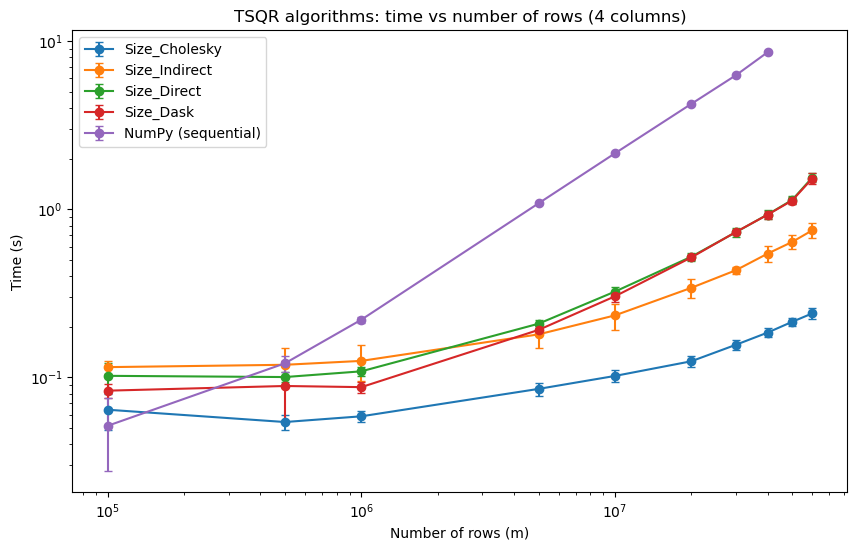

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
for name in algorithms.keys():
    data = np.loadtxt(f"./data/{name}.txt")
    plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], label=name, marker='o', capsize=3)

data_numpy = np.loadtxt("./data/Size_NumPy.txt")
plt.errorbar(data_numpy[:, 0], data_numpy[:, 1], yerr=data_numpy[:, 2], label="NumPy (sequential)", marker='o', capsize=3)
plt.xscale('log')
plt.yscale('log')
plt.title(f"TSQR algorithms: time vs number of rows ({n} columns)")
plt.xlabel("Number of rows (m)")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

All algorithms show an asymptotic behavior that grows linearly with $m$. This is because for tall-and-skinny matrices where $n\ll m$, the complexity of QR decomposition is approximately $\mathcal{O}(m)$. For smaller matrix sizes, sequential computation performs better due to the overhead of parallel implementations.